In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [16]:
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target

X_train, X_test, y_train, linear_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

linear_reg_pred = linear_reg_model.predict(X_test)
linear_reg_mse = mean_squared_error(linear_y_test, linear_reg_pred)
linear_reg_r2 = r2_score(linear_y_test, linear_reg_pred)
print("MSE: ", linear_reg_mse)
print("R^2: ", linear_reg_r2)

MSE:  0.5558915986952419
R^2:  0.5757877060324527


In [2]:
# Load the data
housing_data = pd.read_csv('housing.csv')

# Initital Exploration - Descriptinve statistics
descriptive_stats = print(housing_data.describe())

# Data Cleaning - Missing Values
missing_values = print(housing_data.isnull().sum())

# Data Cleaning - Duplicate Values
duplicates = housing_data.duplicated().sum()
if duplicates > 0:
    housing_data = housing_data.drop_duplicates()
print("Number of duplicate entries removed:", duplicates)

housing_data.head()

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


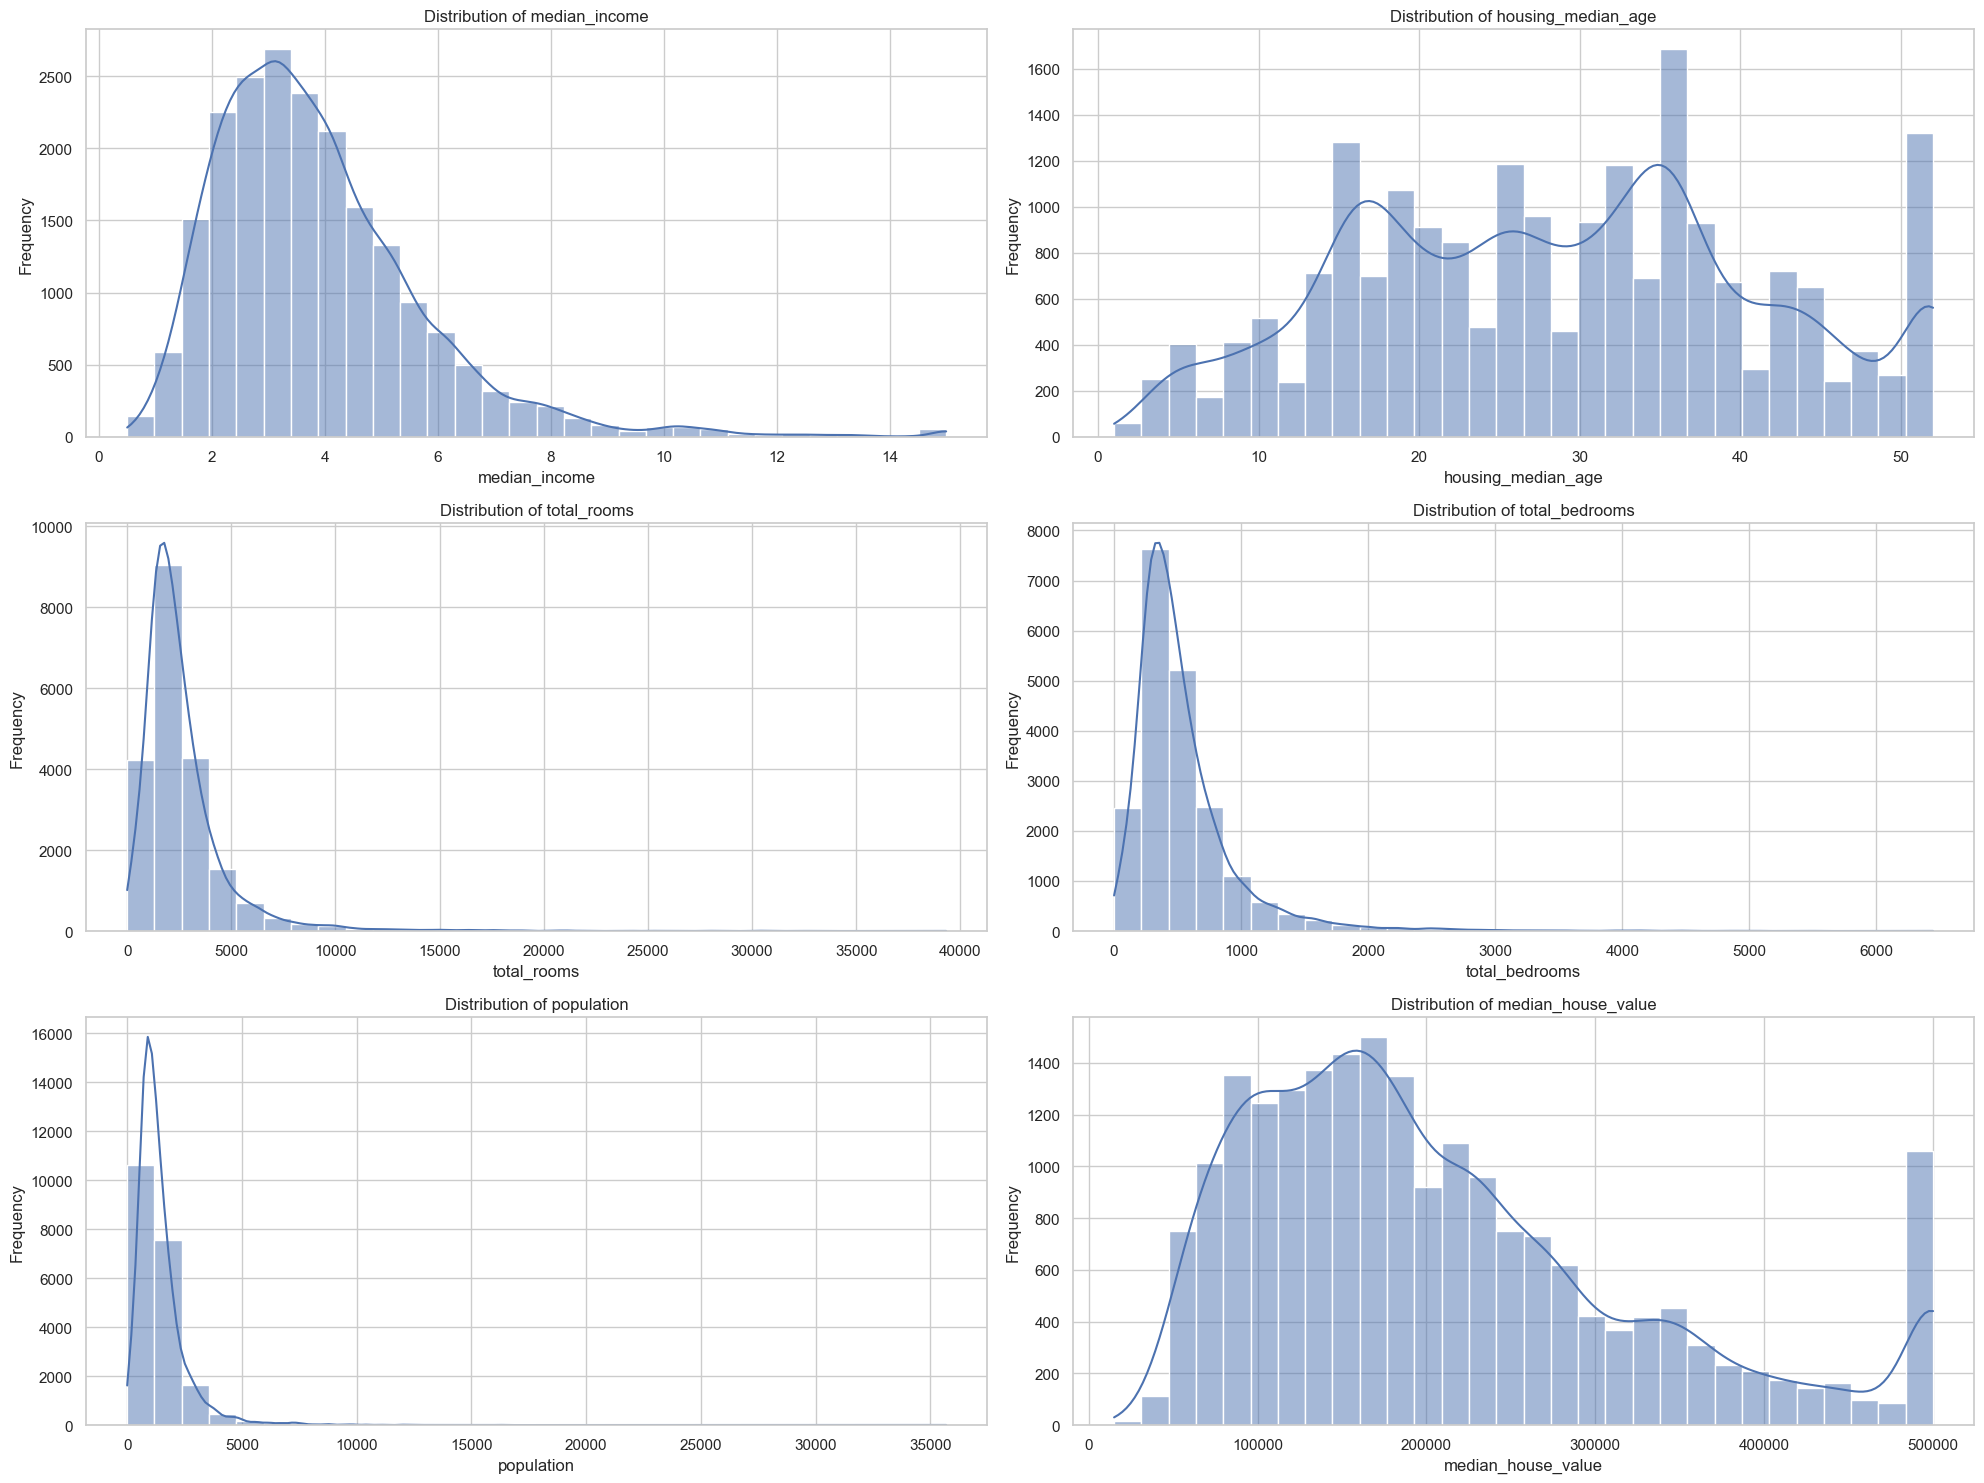

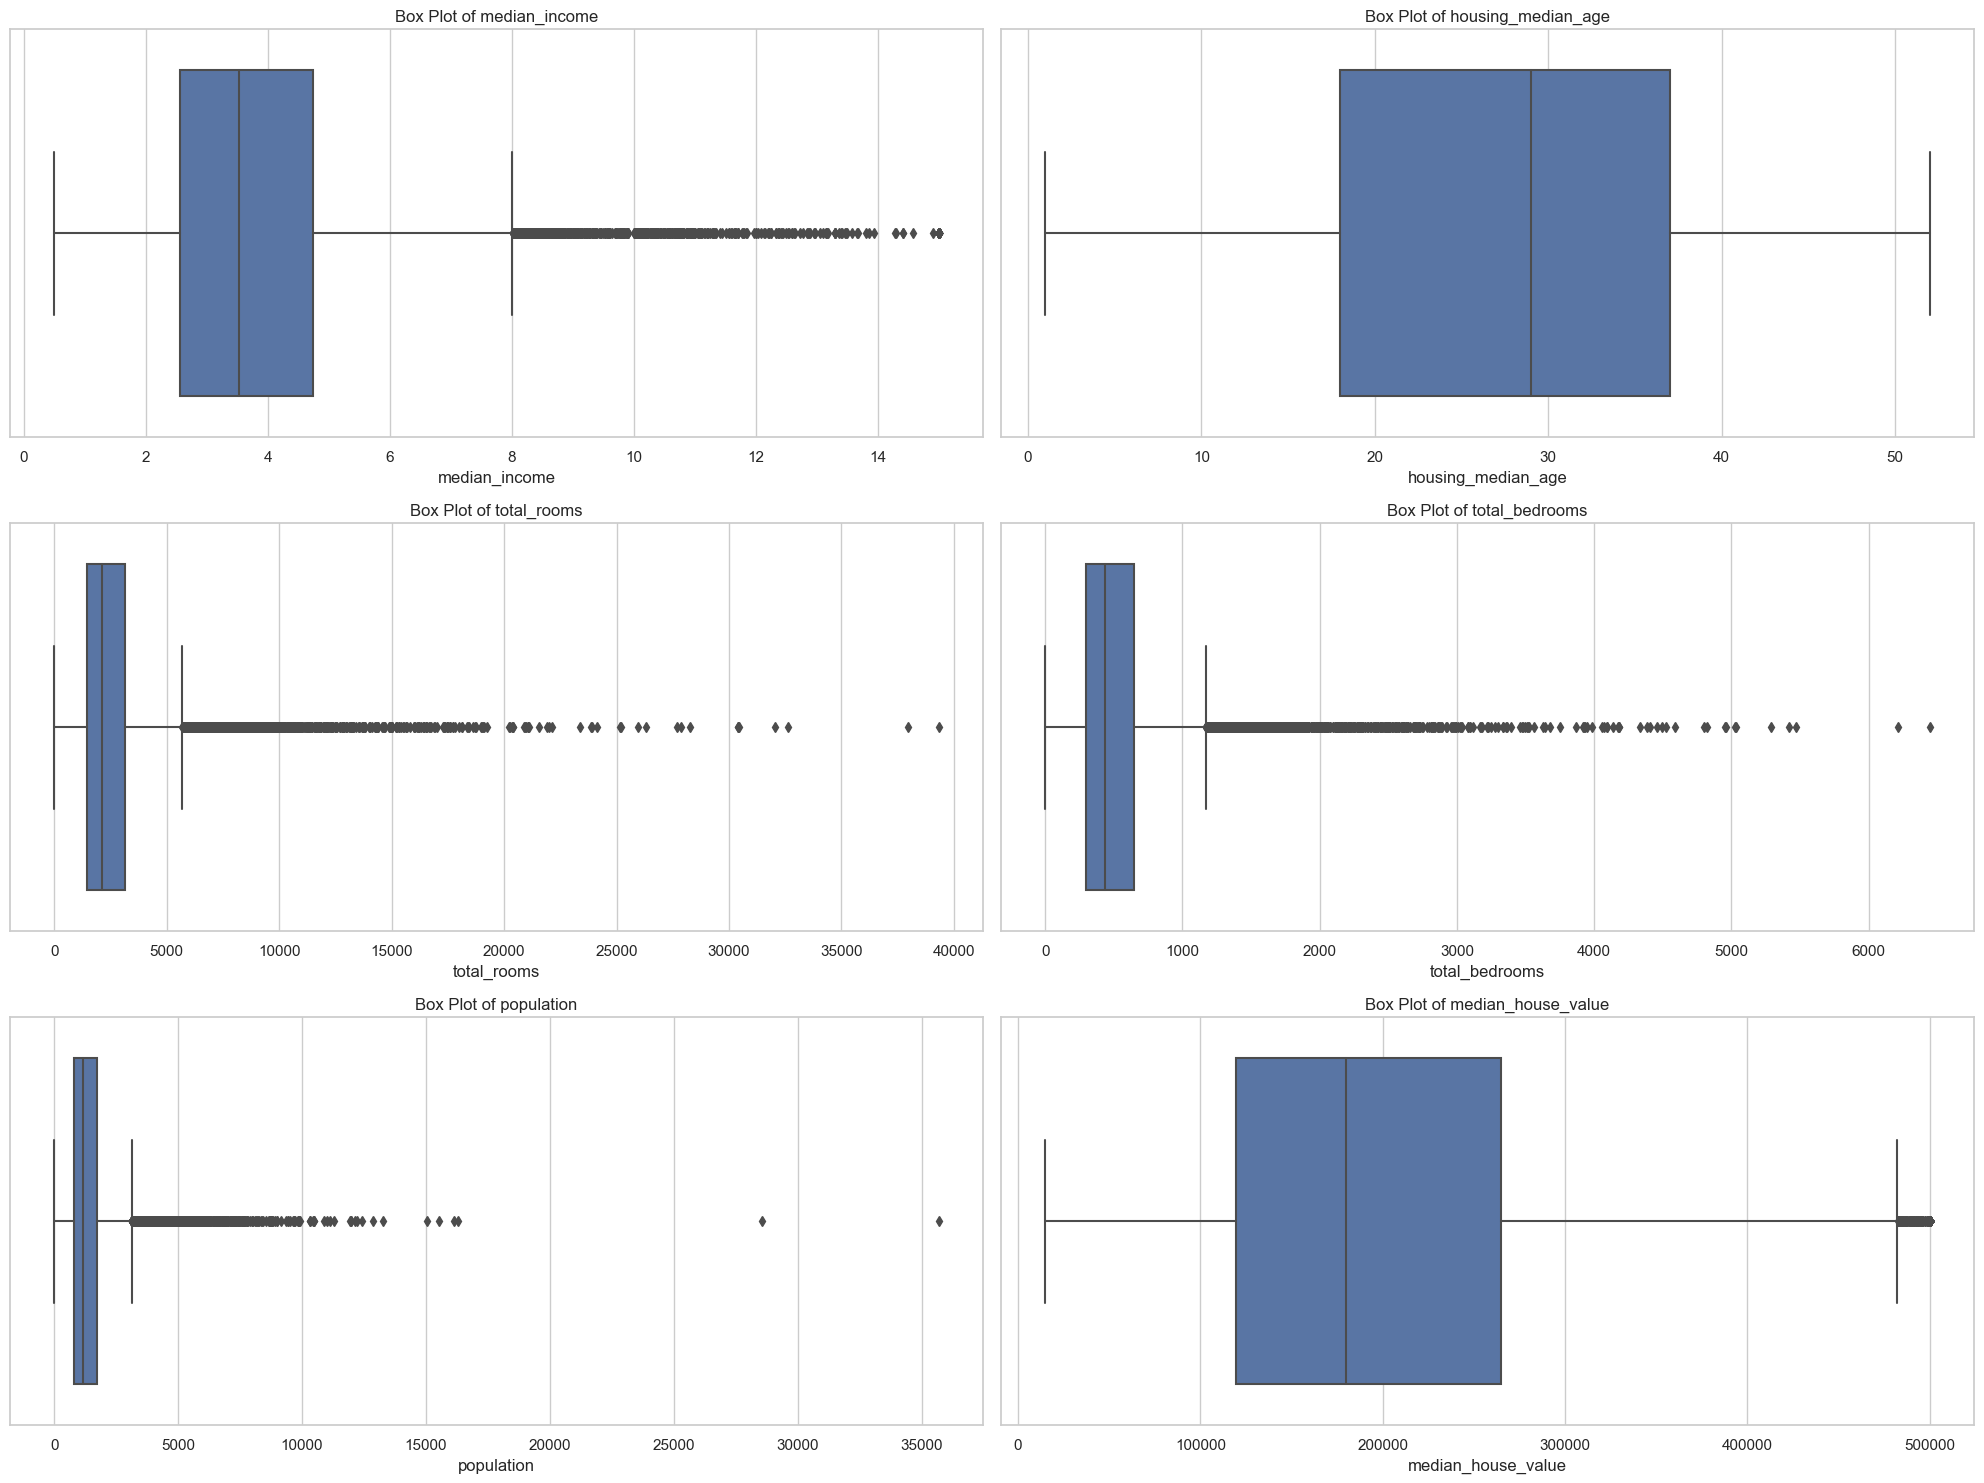

In [4]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# List of features you might be interested in
features = ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'median_house_value']

# Plot histograms for each feature
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(housing_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Plot Box for outliers
# Plot box plots for each feature
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=housing_data[feature])
    plt.title(f'Box Plot of {feature}')
    
plt.tight_layout()
plt.show()

In [3]:
# creating an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

housing_num = housing_data.drop("ocean_proximity", axis=1)

# fitting the imputer to the data
imputer.fit(housing_num)

# transforming the data using the fitted imputer
completed_data = imputer.transform(housing_num)

# converting the numpy array back into a dataframe
completed_frame = pd.DataFrame(completed_data, columns=housing_num.columns, index=housing_num.index)

# Checking if the missing values in total_bedrooms have been imputed
missing_values_after_imputation = completed_frame.isnull().sum()
missing_values_after_imputation

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [4]:
# Handling Outliers and adjusting them to more central values
# Detect outliers using IQR
Q1 = completed_frame.quantile(0.25)
Q3 = completed_frame.quantile(0.75)
IQR = Q3 - Q1

# Calculating the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Adjusting outliers to the nearest boundary value
for column in completed_frame.columns:
    # Lower bound adjustment
    completed_frame[column] = completed_frame[column].mask(completed_frame[column] < lower_bound[column], lower_bound[column])
    # Upper bound adjustment
    completed_frame[column] = completed_frame[column].mask(completed_frame[column] > upper_bound[column], upper_bound[column])

# Identify outlier rows for any column
outliers = ((completed_frame < (Q1 - 1.5 * IQR)) | (completed_frame > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outlier rows: {outliers.sum()}")

Number of outlier rows: 0


In [5]:
# Encoding Categorical Variables
# initalize the encoder
encoder = OneHotEncoder()

# Fit and transform the ocean_proximity column
ocean_proximity_encoded = encoder.fit_transform(housing_data[['ocean_proximity']])

# Convert to DataFrame for easier viewing
ocean_proximity_encoded_df = pd.DataFrame(ocean_proximity_encoded.toarray(), columns=encoder.get_feature_names_out(), index=housing_data.index)

# Display the first few rows of the encoded dataframe
ocean_proximity_encoded_df.head()


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [6]:
# Feature Engineering

# Ratio of bedrooms to total rooms 
housing_data['bedrooms_per_room'] = housing_data['total_bedrooms'] / housing_data['total_rooms']

# Population per household
housing_data['population_per_household'] = housing_data['population'] / housing_data['households']

# Rooms per household
housing_data['rooms_per_household'] = housing_data['total_rooms'] / housing_data['households']

# Population density (people per square mile)
housing_data['population_density'] = housing_data['population'] / housing_data['households']

# Distance to downtown LA in miles
housing_data['distance_to_downtown_la'] = np.sqrt(
    (housing_data['latitude'] - 34.05)**2 + 
    (housing_data['longitude'] + 118.25)**2
)

# One-hot encoding for 'ocean_proximity'
ocean_proximity_encoded = pd.get_dummies(housing_data['ocean_proximity'], prefix='ocean_proximity')
housing_data = pd.concat([housing_data, ocean_proximity_encoded], axis=1)

# Dropping the original 'ocean_proximity' column as it's now encoded
housing_data.drop('ocean_proximity', axis=1, inplace=True)

# Display the first few rows to confirm the new features have been added
housing_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedrooms_per_room,population_per_household,rooms_per_household,population_density,distance_to_downtown_la,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,0.146591,2.555556,6.984127,2.555556,5.523522,False,False,False,True,False
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,0.155797,2.109842,6.238137,2.109842,5.502454,False,False,False,True,False
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,0.129516,2.802260,8.288136,2.802260,5.510000,False,False,False,True,False
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,0.184458,2.547945,5.817352,2.547945,5.517246,False,False,False,True,False
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,0.172096,2.181467,6.281853,2.181467,5.517246,False,False,False,True,False


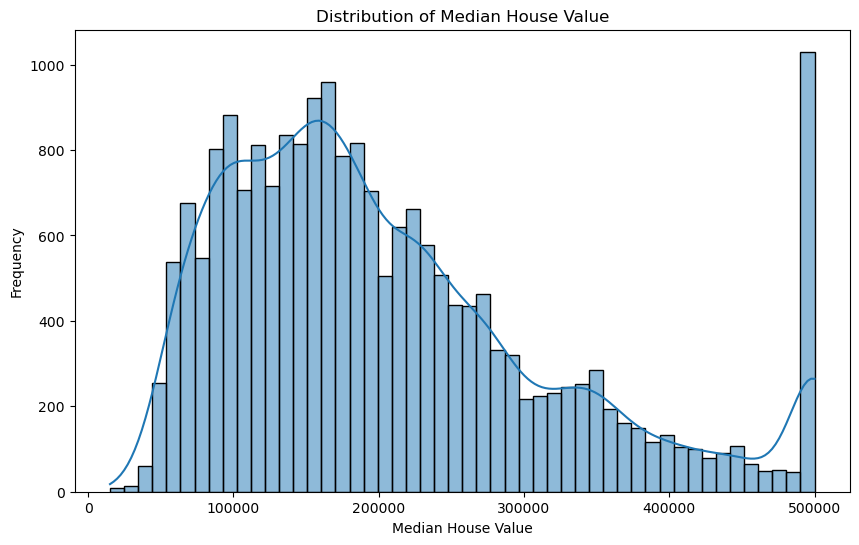

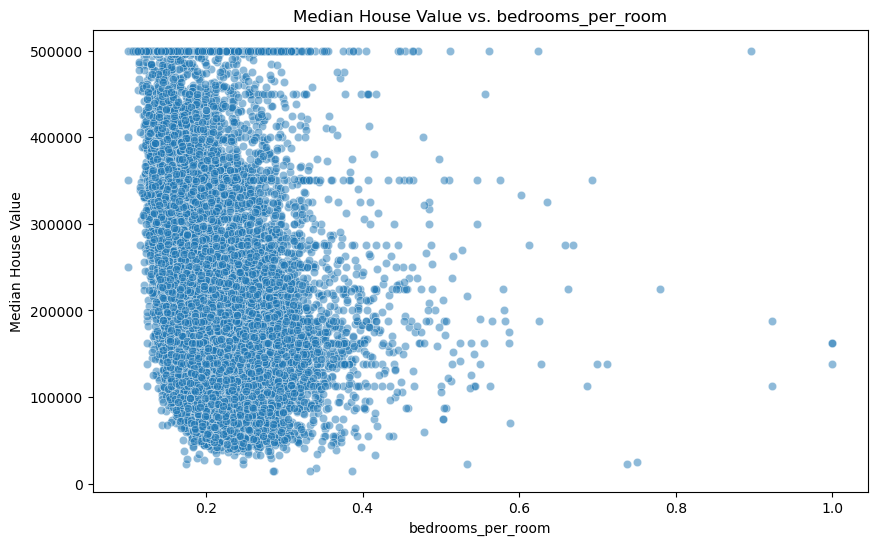

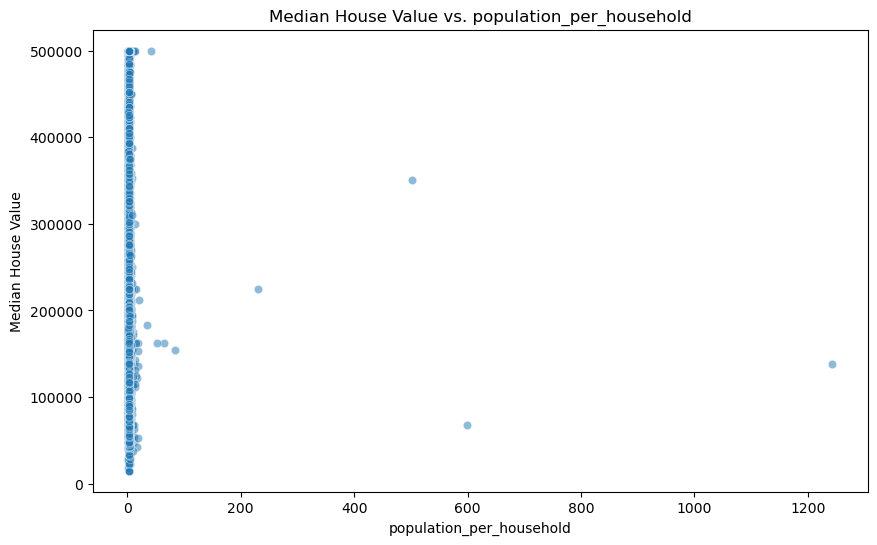

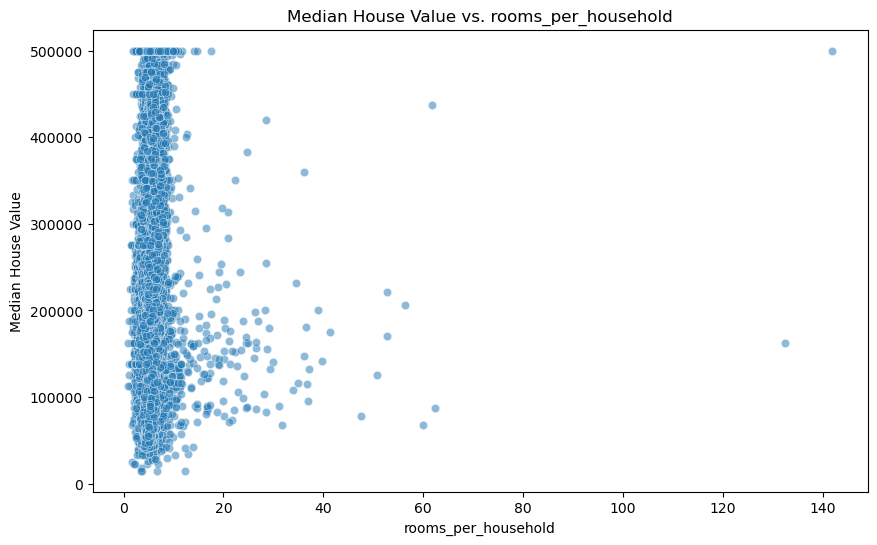

In [7]:
# Visualize the distribution of 'median_house_value'
plt.figure(figsize=(10, 6))
sns.histplot(housing_data['median_house_value'], bins=50, kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between 'median_house_value' and some newly created features
features_to_visualize = ['bedrooms_per_room', 'population_per_household', 'rooms_per_household']
for feature in features_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=housing_data, x=feature, y='median_house_value', alpha=0.5)
    plt.title(f'Median House Value vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Median House Value')
    plt.show()

In [18]:
# Preparing the data for training
imputer = SimpleImputer(strategy='median')
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the imputer on the training data
imputer.fit(X_train)

# Transforming both training and testing data
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaled to normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Training a Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

# Predicting on the test set
random_forest_pred = random_forest_model.predict(X_test_scaled)

# Evaluating the model
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
random_forest_r2 = r2_score(y_test, random_forest_pred)

# Displaying the results
print(f'Mean Squared Error (Random Forest): {random_forest_mse}')
print(f'R-squared Score (Random Forest): {random_forest_r2}')

Mean Squared Error (Random Forest): 2366053656.0624456
R-squared Score (Random Forest): 0.8194415869129156


In [11]:
# Gradient Boosting Regressor

# Initialize the model with default parameters.
gbf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data.
gbf.fit(X_train_scaled, y_train)

# Predict on the test data
gbf_predictions = gbf.predict(X_test_scaled)

# Calculate mean squared error of our predictions vs actual values.
gradient_boosting_mse = mean_squared_error(y_test, gbf_predictions)
gradient_boosting_r2 = r2_score(y_test, gbf_predictions)

# Print the evaluation metrics
print("Mean Squared Error:", gradient_boosting_mse)
print("R-Squared Score:", gradient_boosting_r2)

Mean Squared Error: 2778312529.6931815
R-Squared Score: 0.7879812657096715


In [13]:
# Initialize the Linear Regression model
# linear_reg = LinearRegression()

# # Fit the model to the scaled training data
# linear_reg.fit(X_train_scaled, y_train)

# # Predict on the scaled test set
# linear_reg_predictions = linear_reg.predict(X_test_scaled)

# # Evaluate the model
# linear_reg_mse = mean_squared_error(y_test, linear_reg_predictions)
# linear_reg_r2 = r2_score(y_test, linear_reg_predictions)

# print(f"Linear Regression MSE: {linear_reg_mse}")
# print(f"Linear Regression R-squared: {linear_reg_r2}")

Linear Regression MSE: 4708169991.646284
Linear Regression R-squared: 0.6407098799058477


In [12]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGB MSE: {xgb_mse}, R2: {xgb_r2}")

XGB MSE: 2114256022.3852549, R2: 0.8386567813948098


In [28]:
model_performance = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGB Regressor'],
    'MSE': [linear_reg_mse, random_forest_mse, gradient_boosting_mse, xgb_mse],
    'R-squared': [linear_reg_r2, random_forest_r2, gradient_boosting_r2, xgb_r2]
}
model_performance['MSE'] = [f"{mse:.5f}" for mse in model_performance['MSE']]

model_performance_df = pd.DataFrame(model_performance)
print(model_performance_df)

               Model               MSE  R-squared
0  Linear Regression           0.55589   0.575788
1      Random Forest  2366053656.06245   0.819442
2  Gradient Boosting  2778312529.69318   0.787981
3      XGB Regressor  2114256022.38525   0.838657


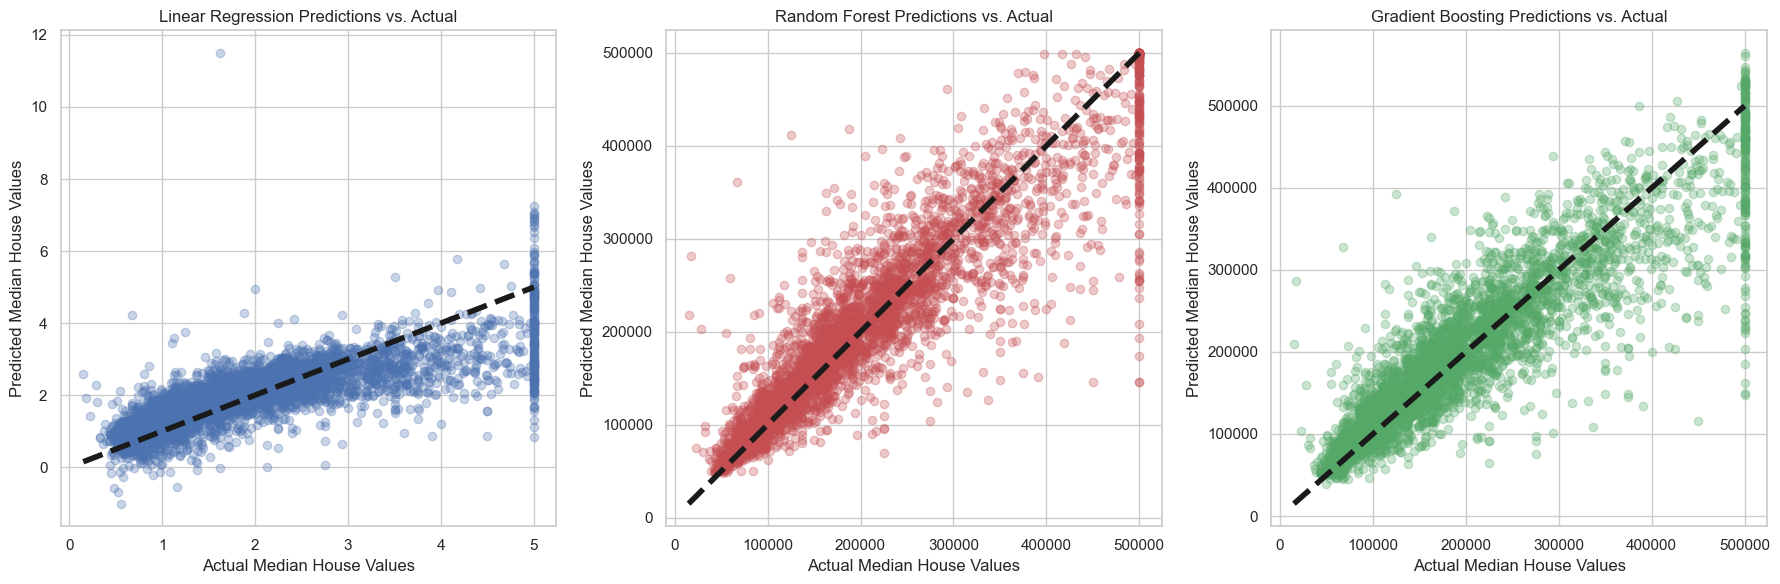

In [30]:
# Visualizing the linear regression against the random forest regression and gradient boosting regression

# Actual vs Predicted scatter plot for Linear Regression
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(linear_y_test, linear_reg_pred, alpha=0.3)
plt.title('Linear Regression Predictions vs. Actual')
plt.xlabel('Actual Median House Values')
plt.ylabel('Predicted Median House Values')
plt.plot([linear_y_test.min(), linear_y_test.max()], [linear_y_test.min(), linear_y_test.max()], 'k--', lw=4)

# Actual vs Predicted scatter plot for Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, random_forest_pred, alpha=0.3, color='r')
plt.title('Random Forest Predictions vs. Actual')
plt.xlabel('Actual Median House Values')
plt.ylabel('Predicted Median House Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4) 

# Actual vs Predicted scatter plot for Gradient Boosting Regressor
plt.subplot(1, 3, 3)
plt.scatter(y_test, gbf_predictions, alpha=0.3, color='g')
plt.title('Gradient Boosting Predictions vs. Actual')
plt.xlabel('Actual Median House Values')
plt.ylabel('Predicted Median House Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4) 

plt.tight_layout()
plt.show()

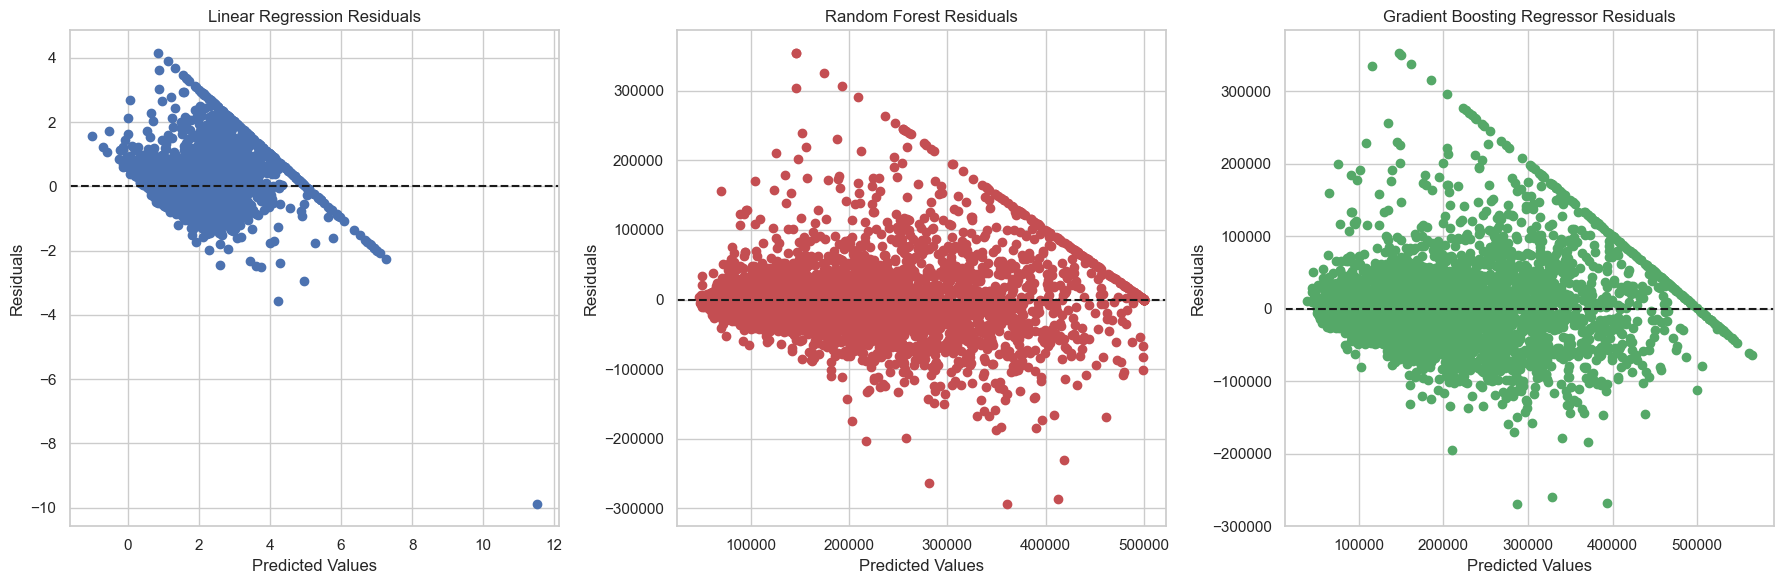

In [32]:
# Residual plot for Linear Regression
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(linear_reg_pred, linear_y_test - linear_reg_pred)
plt.title('Linear Regression Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')

# Residual plot for Random Forest
plt.subplot(1, 3, 2)
plt.scatter(random_forest_pred, y_test - random_forest_pred, color='r')
plt.title('Random Forest Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')

# Residual plot for Gradient Boosting Regressor
plt.subplot(1, 3, 3)
plt.scatter(gbf_predictions, y_test - gbf_predictions, color='g')
plt.title('Gradient Boosting Regressor Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')

plt.tight_layout()
plt.show()

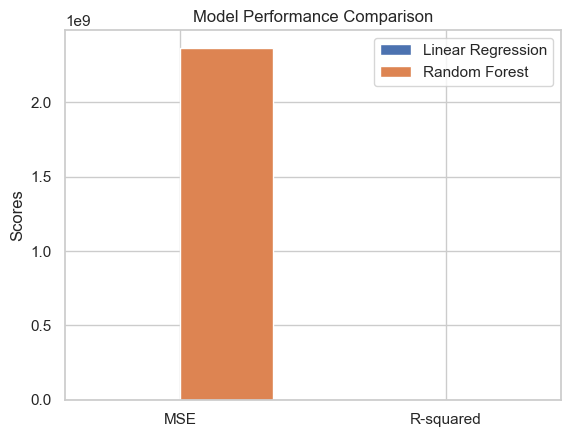

In [23]:
metrics = ['MSE', 'R-squared']
values_lr = [linear_reg_mse, linear_reg_r2]
values_rf = [random_forest_mse, random_forest_r2] 

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_lr, width, label='Linear Regression')
rects2 = ax.bar(x + width/2, values_rf, width, label='Random Forest')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Params:", grid_search_rf.best_params_)